<a href="https://www.kaggle.com/code/sofiamatias/icecube-train?scriptVersionId=124850284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Concepts and ideas

This notebook attempts at creating a model to predict/estimate a given neutrino direction, from a set of coordinates measured by several sensors in one event. 

A neural network was defined having in mind this is a regression problem:
 - 5  linear layers
 - RELU as activation function
 - L1Loss as model metric
 - ADAM as optimizer
 
LGBM machine learning model was attempted, but it perform poorly, especially in computation time. Score from test set was 1.558 and since the model can't use further trees (because it increases computation time directly with the amount of batches trained) this solution was abandoned. 

## How zenith and azimuth gives a direction
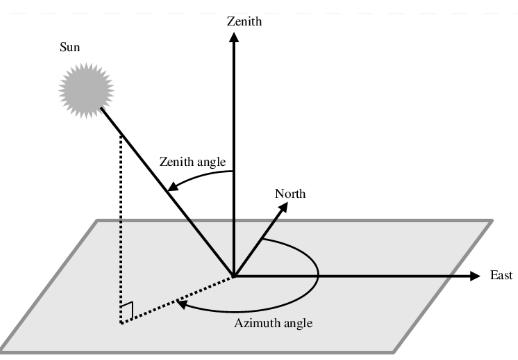

# Merge Data

In [1]:
def get_train_df_from_a_batch (train_batch_df, sensors_df, train_meta_df, batch_number):
    """
    Converts train_batch, train_meta and sensor_geometry into a 'train_df' dataframe containing features and targets
    It filters 'auxiliary' field to only 'False' values (reduces db in 27%), due to challenge explanation:
    ' If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise.'
    It uses polars dataframes only.
    """
    train_batch_df = train_batch_df.filter(pl.col("auxiliary") == False)
    sensors_df = sensors_df.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    train_df = train_batch_df.join (sensors_df, how='left', on = 'sensor_id')
    train_meta_batch_df = train_meta_df.filter(pl.col("batch_id") == batch_number)
    train_df = train_df.join (train_meta_batch_df, how='left', on = 'event_id')
    train_df = train_df.drop (columns=['batch_id', 'auxiliary']) #train_df is filtered for 1 batch_id and auxiliary = False, these columns are useless
    train_df = train_df.drop (columns=['sensor_id', 'first_pulse_index', 'last_pulse_index'])
    #train_df = train_df.with_columns(xy = pl.col('x') * pl.col('y'))
    del train_meta_batch_df #memory
    del train_batch_df #memory
    print (f'Train dataframe:\n')
    print (train_df)
    return train_df

# 3D Plotting

In [2]:
def plot_3D (trn_df, event_num):
    """
    Plots x, y, and z from sensors vs azimuth and zenith calculated, per 1 event
    """
    # Get x, y, z, azimuth and zenith values from sensors
    train_df = trn_df.filter(pl.col("event_id") == event_num)
    m = 0
    M = len(train_df.collect())

    xs = train_df.collect()[m:M, 'x']
    ys = train_df.collect()[m:M, 'y']
    zs = train_df.collect()[m:M, 'z']
    azim = train_df.collect()[m:M, 'azimuth']
    zen = train_df.collect()[m:M, 'zenith']

    # Calculate the Cartesian coordinates of the vector
    xp = np.sin(zen) * np.cos(azim)
    yp = np.sin(zen) * np.sin(azim)
    zp = np.cos(zen)

    # Set figure
    fig = plt.figure(figsize = (12,20))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vector as a line from (0,0,0) to (x,y,z)
    ax.scatter(xp, yp, zp, color='g')
    ax.scatter(xs,ys,zs, color='b')

    # Add labels for the x, y, and z axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.title(f"Event {event_num}")

    # Show the plot
    plt.show()

# EDA

In [3]:
def EDA_report (data):
    """
    Generates an EDA report using sweetviz package. Use "data" as your dataset
    """
    import datetime
    import sweetviz as sw
    from IPython.display import FileLink, display

    now = datetime.datetime.now()
    report_filename = f'EDA_report{now}.html'

    analyze_report = sw.analyze(data)
    analyze_report.show_html(report_filename, open_browser = True)
    
    link = FileLink (report_filename)
    print ('\nClick here to open report:')
    display(link)

    return None

## Correlations

In [4]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    
    from sklearn.feature_selection import mutual_info_regression
    
    for colname in ["object", "category"]:
        if colname in X.dtypes:
            X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#X = train_analysis.to_pandas()
#y_az = X['azimuth']
#X = X.drop (columns = ['azimuth'])
#mi_scores = make_mi_scores(X, y_az)
#del train_analysis #memory
#mi_scores

# Score Function

In [5]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred, batch_size=1):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    import numexpr as ne

    n = len(az_true)
    angle_sum = 0.0
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        sa1 = np.sin(az_true[i:end]).astype(np.float32)
        ca1 = np.cos(az_true[i:end]).astype(np.float32)
        sz1 = np.sin(zen_true[i:end]).astype(np.float32)
        cz1 = np.cos(zen_true[i:end]).astype(np.float32)
        sa2 = np.sin(az_pred[i:end]).astype(np.float32)
        ca2 = np.cos(az_pred[i:end]).astype(np.float32)
        sz2 = np.sin(zen_pred[i:end]).astype(np.float32)
        cz2 = np.cos(zen_pred[i:end]).astype(np.float32)
        scalar_prod = ne.evaluate('sz1*sz2*(ca1*ca2 + sa1*sa2) + cz1*cz2')
        scalar_prod = np.clip(scalar_prod, -1, 1)
        angle_sum += np.sum(np.arccos(scalar_prod))
    return angle_sum / (n * batch_size) 

# Train and score a regression neural network

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.drop(columns=['azimuth', 'zenith']).to_numpy()
        self.targets = self.df[['azimuth', 'zenith']].to_numpy()
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        features = self.features[idx] #maybe we need to apply the scaler here again
        target = self.targets[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

    
class CustomModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 8)
        self.fc5 = torch.nn.Linear(8, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def train_model(train_dataset, batch_size, num_epochs, learning_rate, device, model_path=None):
    scores = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = CustomModel(input_size=train_dataset.features.shape[1], output_size=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = torch.nn.L1Loss()

    if os.path.exists (model_path):
        model.load_state_dict(torch.load(model_path))

    model.to(device)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        #print('Epoch {} loss: {}'.format(epoch+1, running_loss / len(train_loader)))
        scores.append (running_loss / len(train_loader)) 

        if model_path is not None:
            torch.save(model.state_dict(), model_path)
    score = np.mean(scores)

    return model, score

def predict_model(test_dataset, batch_size, device, model_path):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = CustomModel(input_size=test_dataset.features.shape[1], output_size=2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())

    return np.array(predictions)

# Model train

## Imports

In [7]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pandas as pd
import os, gc

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS, mean_absolute_error
import optuna
from tqdm import tqdm
from torch import cuda

print ('\nFinished loading imports.\n')

if cuda.is_available():
    device_lgbm = 'gpu'
    device_nn = 'cuda'
else:
    device_lgbm = 'cpu'
    device_nn = 'cpu'
    
print (f"Device for training is {device_lgbm}.\n")

input_path = '/kaggle/input/'
work_path = '/kaggle/working/'
scores_nn_path = f'{work_path}scores_nn.csv'
scores_nn_df = pd.DataFrame([])
model_path = f'{work_path}model.pt'
saved_scores_nn_path = f'{input_path}scores_nn.csv'
saved_model_path = f'{input_path}model.pt'

for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'sensor' in filepath:
            sensors_df = pl.read_csv (filepath).lazy()
            print ("'sensor_geometry' file loaded.")
        elif 'score' in filepath:
            scores_nn_df = pd.read_csv (filepath)
        elif 'train_meta' in filepath:
            train_meta_filepath = filepath
            print ("'train_meta' file path found and loaded.")
print ('\nAll paths are set.\n')


Finished loading imports.

Device for training is gpu.

'train_meta' file path found and loaded.
'sensor_geometry' file loaded.

All paths are set.

CPU times: user 1.25 s, sys: 201 ms, total: 1.45 s
Wall time: 2.53 s


## 3D Plotting and EDA

In [8]:
#train_analysis = train_df.collect().sample(frac=0.001)
#EDA_report (train_analysis.to_pandas())

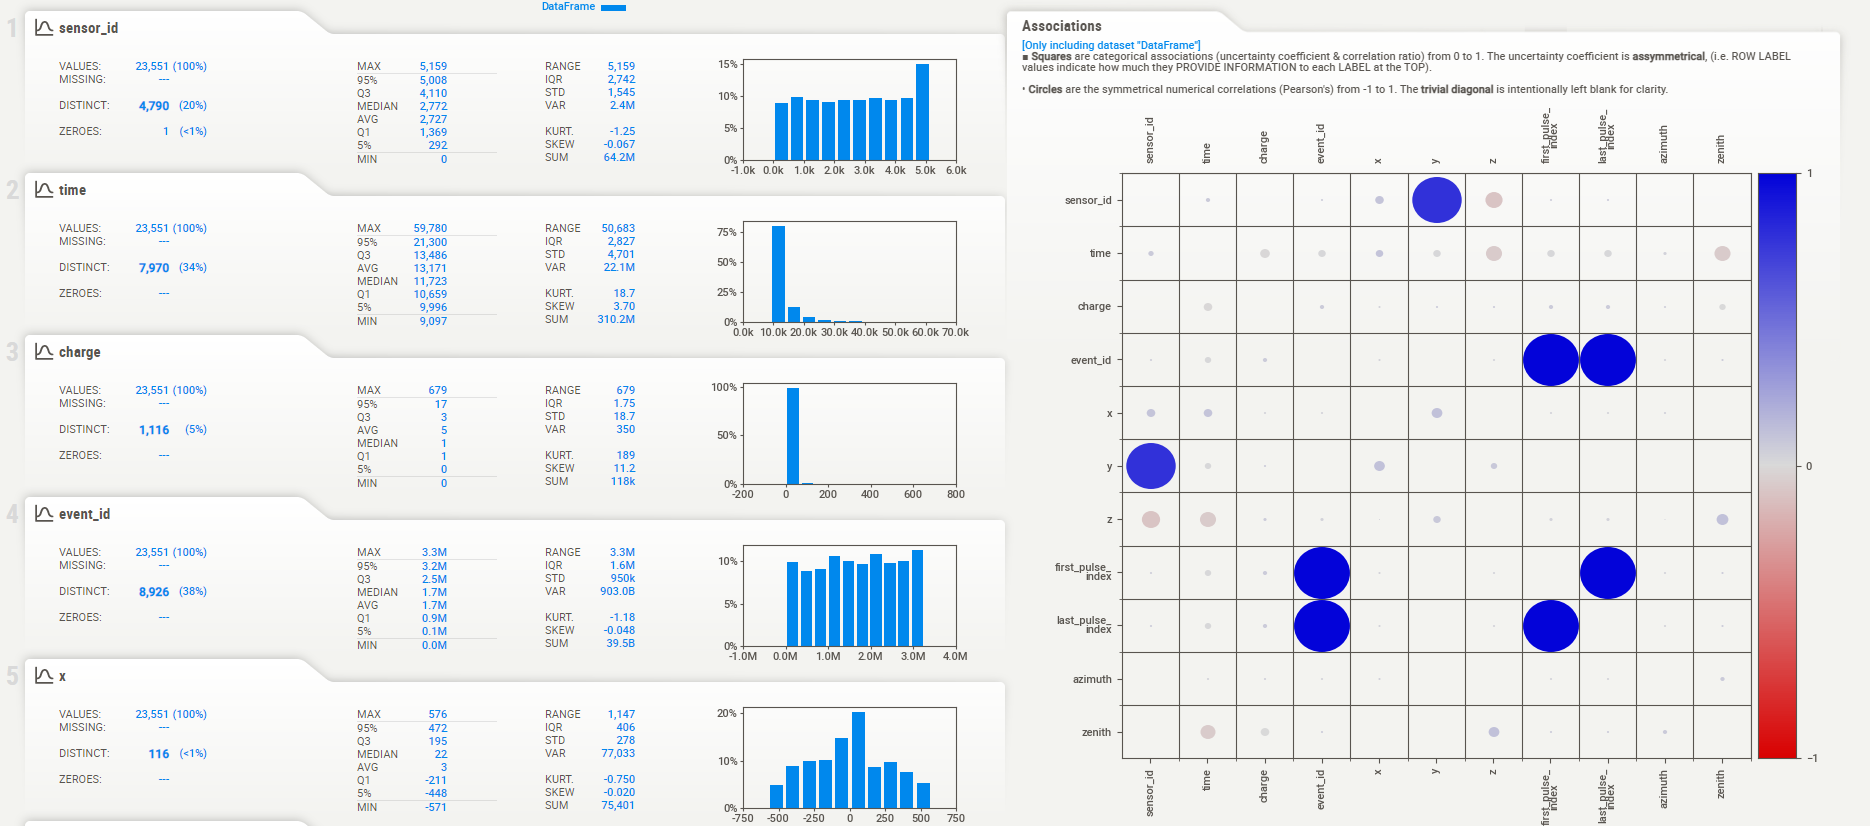
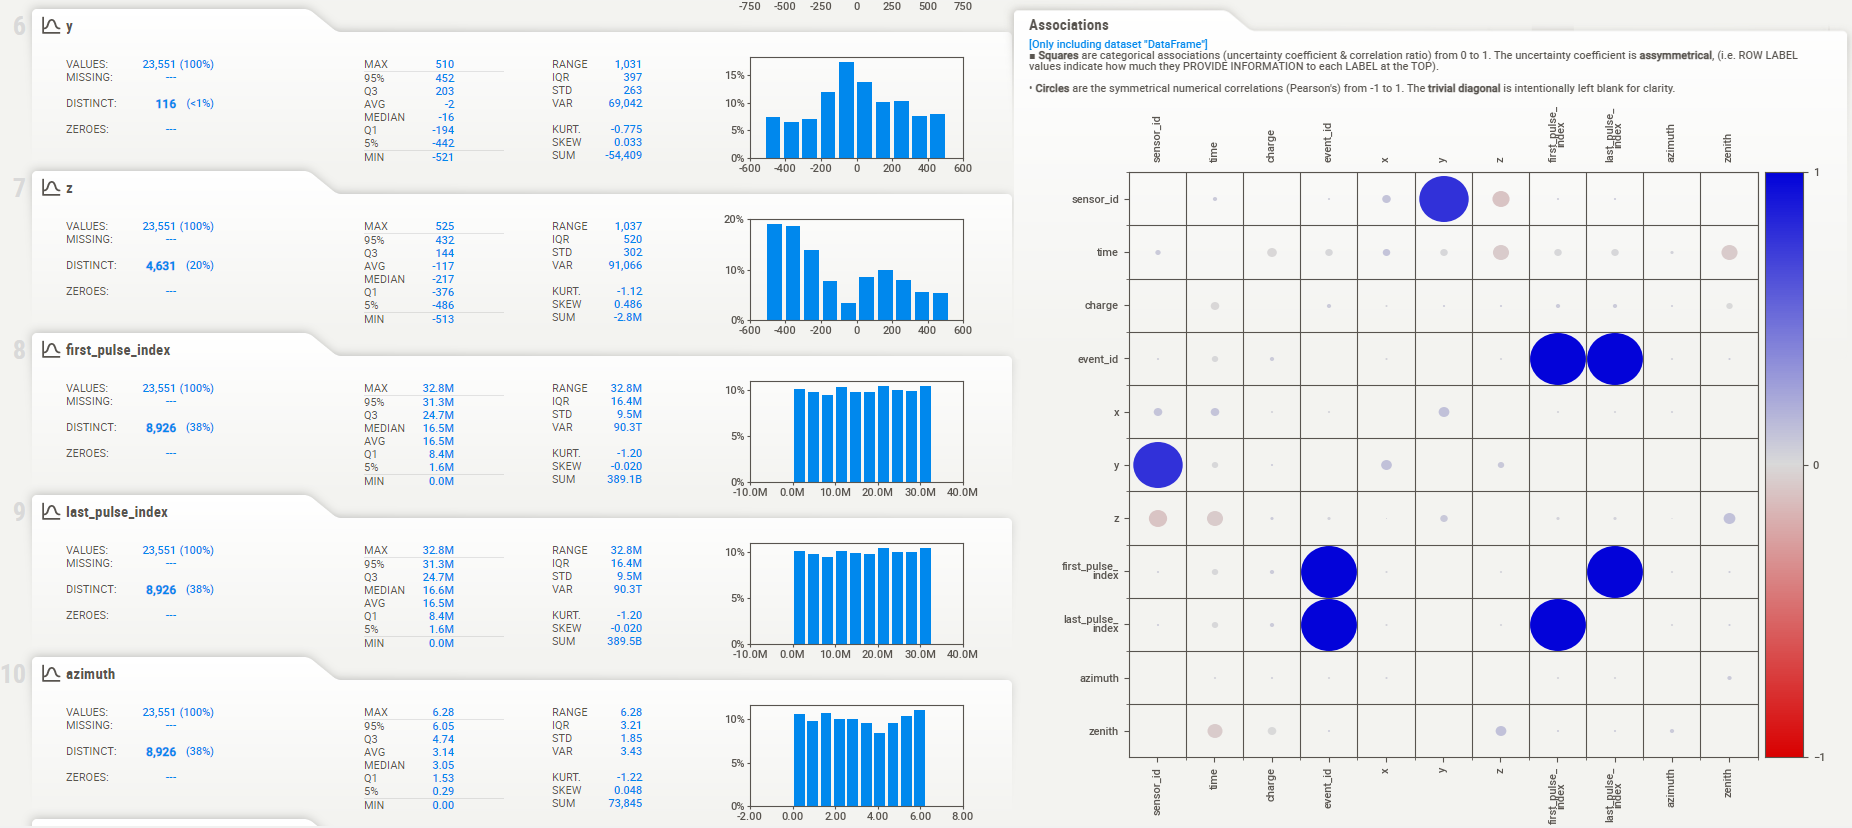

In [9]:
#%matplotlib inline
#3D plotting of batch 1
#batch_1_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet'
#train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
#train_batch_df = pl.read_parquet (batch_1_path).lazy()
#train_df = get_train_df_from_a_batch (train_batch_df.collect(), sensors_df.collect(), train_meta_df.collect(), 1).lazy()
#del train_batch_df #memory
#del train_meta_df #memory
#plot_3D(train_df, 3266196) #event_id = 3266196

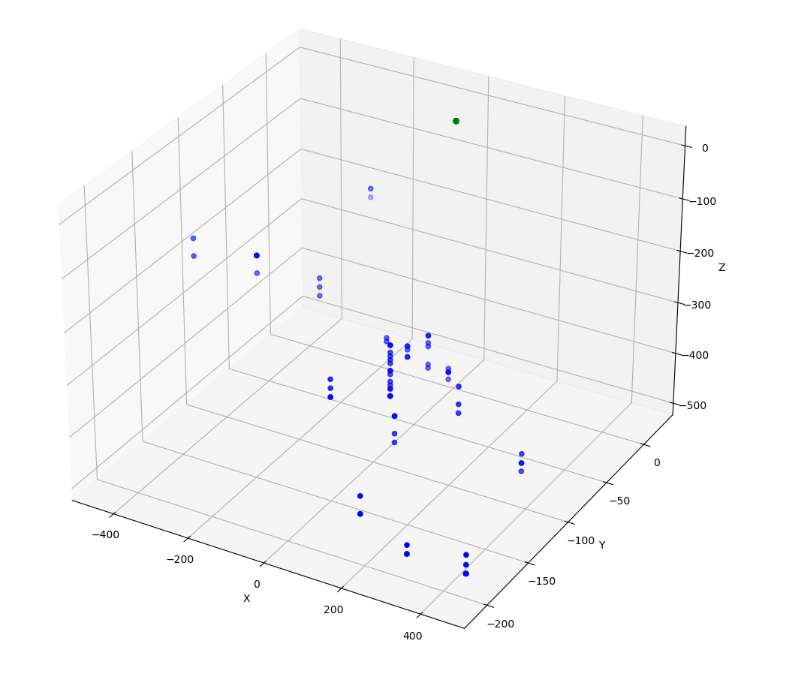

## Train model

In [10]:
%%time
y_preds = []
submission_df = pl.DataFrame([]).lazy()
counts = 1
max = 5
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if ('batch' in filepath) and ('train' in dirname):
            batch_number = int (filename.split('_')[1].split('.')[0])
            print (f"TRAINING BATCH ID {batch_number} - {counts} BATCHES OF {max}\n\ntrain_batch_{batch_number}' file loaded.\n\n")
            if len(scores_nn_df) != 0 and (batch_number in scores_nn_df.batch_id.values):
                print ('\nBatch already trained. Skipping to next batch.\n')
                continue
            train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
            print ("'train_meta' file loaded.")
            train_batch_df = pl.read_parquet (filepath).lazy()
            print (f"\nLoading 'train_batch' file.\n")
            print (train_batch_df.collect())
            train_df = get_train_df_from_a_batch (train_batch_df.collect(), 
                                                  sensors_df.collect(), 
                                                  train_meta_df.collect(), 
                                                  batch_number)
            del train_meta_df #memory
            del train_batch_df
            gc.collect()
            train_df = train_df.sample(frac=0.05)
            trn_df, tst_df = train_test_split(train_df, test_size=0.2, random_state=42)
            print ('\nTraining model...\n')
            print (trn_df)
            train_dataset = CustomDataset(trn_df)
            if os.path.exists (saved_model_path):
                model_filepath = saved_model_path
            else:
                model_filepath = model_path
            model, m_score = train_model(train_dataset,
                                         batch_size=128, 
                                         num_epochs=10, 
                                         learning_rate=1e-3, 
                                         device=device_nn, 
                                         model_path=model_filepath)
            del train_df #memory
            del trn_df
            del train_dataset #memory
            gc.collect()
            print ('\nModel score:', m_score)
            print ('\nPredicting values for model score...\n')
            print (tst_df)
            test_dataset = CustomDataset(tst_df)
            y_preds.append (predict_model(test_dataset, batch_size=128, device=device_nn, model_path=model_filepath))
            y_pred = np.array(y_preds).reshape(-1, 2)
            y_preds = []
            torch.cuda.empty_cache()
            az_pred = y_pred [:,0]
            print ('\nAzimuth preds:\n', az_pred)
            ze_pred = y_pred [:,1]
            print ('\nZenith preds:\n', ze_pred)
            i = np.random.choice (list(range(0,len(az_pred))), int(len(az_pred) * 1), replace=False)
            score = angular_dist_score(tst_df['azimuth'].to_numpy()[i], tst_df['zenith'].to_numpy()[i], az_pred[i], ze_pred[i])
            print ('\nScore:', score)
            print ('\nCache cleaned.\n')
            if len(scores_nn_df) != 0:
                scores_nn_df = scores_nn_df.append (pd.DataFrame ([{'batch_id': batch_number, 'score': score}]))
            else:
                scores_nn_df = pd.DataFrame ([{'batch_id': batch_number, 'score': score}])
            scores_nn_df.to_csv (scores_nn_path, index=False)
            print (scores_nn_df)
            batch_results = {'event_id': tst_df['event_id'], 
                             'azimuth_pred': az_pred, 
                             'zenith_pred': ze_pred, 
                             'azimuth_true': tst_df['azimuth'],
                             'zenith_true': tst_df['zenith']}
            del test_dataset #memory
            del tst_df
            gc.collect()
            batch_results_df = pl.DataFrame (batch_results).lazy()
            if submission_df.select(pl.count()).collect()[0,0] == 0:
                submission_df = batch_results_df
            else:
                submission_df = pl.concat ([submission_df, batch_results_df])
            if counts == max:
                break
            counts += 1

TRAINING BATCH ID 240 - 1 BATCHES OF 5

train_batch_240' file loaded.


'train_meta' file loaded.

Loading 'train_batch' file.

shape: (32_801_416, 5)
┌───────────┬───────┬────────┬───────────┬───────────┐
│ sensor_id ┆ time  ┆ charge ┆ auxiliary ┆ event_id  │
│ ---       ┆ ---   ┆ ---    ┆ ---       ┆ ---       │
│ i16       ┆ i64   ┆ f64    ┆ bool      ┆ i64       │
╞═══════════╪═══════╪════════╪═══════════╪═══════════╡
│ 2024      ┆ 6029  ┆ 1.425  ┆ true      ┆ 777938857 │
│ 2371      ┆ 6078  ┆ 1.475  ┆ true      ┆ 777938857 │
│ 920       ┆ 6508  ┆ 0.425  ┆ true      ┆ 777938857 │
│ 4872      ┆ 7886  ┆ 0.475  ┆ true      ┆ 777938857 │
│ …         ┆ …     ┆ …      ┆ …         ┆ …         │
│ 1626      ┆ 27878 ┆ 0.275  ┆ true      ┆ 781200050 │
│ 4818      ┆ 28174 ┆ 1.425  ┆ true      ┆ 781200050 │
│ 1145      ┆ 28206 ┆ 0.975  ┆ true      ┆ 781200050 │
│ 2927      ┆ 28652 ┆ 0.675  ┆ true      ┆ 781200050 │
└───────────┴───────┴────────┴───────────┴───────────┘
Train dataframe:

shape:

100%|██████████| 10/10 [03:39<00:00, 21.96s/it]



Model score: 1.0738780128729242

Predicting values for model score...

shape: (235_675, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ time  ┆ charge ┆ event_id  ┆ x       ┆ y       ┆ z       ┆ azimuth  ┆ zenith   │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64   ┆ f64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│ 48649 ┆ 1.125  ┆ 778043014 ┆ 544.07  ┆ 55.89   ┆ -280.17 ┆ 2.226737 ┆ 1.505781 │
│ 11522 ┆ 1.375  ┆ 780290541 ┆ 544.07  ┆ 55.89   ┆ -144.0  ┆ 0.185453 ┆ 1.551806 │
│ 13526 ┆ 0.525  ┆ 779701387 ┆ 106.94  ┆ 27.09   ┆ -490.16 ┆ 4.175902 ┆ 1.419446 │
│ 11024 ┆ 0.725  ┆ 781094073 ┆ -481.6  ┆ 101.39  ┆ 161.64  ┆ 4.64317  ┆ 1.829676 │
│ …     ┆ …      ┆ …         ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        │
│ 12915 ┆ 1.225  ┆ 778112183 ┆ 382.35  ┆ 238.9   ┆ 90.05   ┆ 0.686197 ┆ 3.0256

100%|██████████| 10/10 [03:56<00:00, 23.68s/it]



Model score: 1.0367520057668802

Predicting values for model score...

shape: (251_020, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ time  ┆ charge ┆ event_id  ┆ x       ┆ y       ┆ z       ┆ azimuth  ┆ zenith   │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64   ┆ f64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│ 11288 ┆ 1.075  ┆ 960255681 ┆ -358.44 ┆ 120.56  ┆ -233.83 ┆ 2.123283 ┆ 2.287898 │
│ 10751 ┆ 2.475  ┆ 959769689 ┆ 114.39  ┆ -461.99 ┆ -369.39 ┆ 6.206027 ┆ 1.451748 │
│ 16433 ┆ 1.325  ┆ 959371245 ┆ -200.55 ┆ -74.03  ┆ -395.7  ┆ 5.587011 ┆ 1.128441 │
│ 14764 ┆ 7.875  ┆ 958408635 ┆ -392.38 ┆ 334.24  ┆ -365.26 ┆ 4.977563 ┆ 1.398692 │
│ …     ┆ …      ┆ …         ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        │
│ 12159 ┆ 0.875  ┆ 957505029 ┆ -437.04 ┆ 217.8   ┆ 195.09  ┆ 1.916749 ┆ 1.0395

100%|██████████| 10/10 [03:31<00:00, 21.15s/it]



Model score: 1.0347370712934265

Predicting values for model score...

shape: (227_366, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ time  ┆ charge ┆ event_id  ┆ x       ┆ y       ┆ z       ┆ azimuth  ┆ zenith   │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64   ┆ f64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│ 12582 ┆ 1.075  ┆ 512227063 ┆ -166.4  ┆ -287.79 ┆ -489.42 ┆ 0.728121 ┆ 1.558941 │
│ 23735 ┆ 2.525  ┆ 513940850 ┆ 500.43  ┆ -58.45  ┆ -196.0  ┆ 4.008743 ┆ 1.074849 │
│ 9952  ┆ 5.725  ┆ 511619433 ┆ -347.88 ┆ 451.52  ┆ 195.63  ┆ 1.157309 ┆ 0.702375 │
│ 9903  ┆ 12.875 ┆ 512929154 ┆ -403.14 ┆ 3.49    ┆ -383.27 ┆ 0.460269 ┆ 2.604592 │
│ …     ┆ …      ┆ …         ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        │
│ 12133 ┆ 4.975  ┆ 514069343 ┆ 330.03  ┆ 127.2   ┆ -418.25 ┆ 4.429899 ┆ 1.2359

100%|██████████| 10/10 [03:39<00:00, 21.98s/it]



Model score: 1.022247592644008

Predicting values for model score...

shape: (235_687, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ time  ┆ charge ┆ event_id  ┆ x       ┆ y       ┆ z       ┆ azimuth  ┆ zenith   │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64   ┆ f64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│ 10653 ┆ 29.375 ┆ 110967852 ┆ -290.66 ┆ -307.38 ┆ 61.61   ┆ 1.981429 ┆ 1.259563 │
│ 28612 ┆ 2.925  ┆ 111610069 ┆ -313.6  ┆ 237.44  ┆ 501.19  ┆ 1.324184 ┆ 1.268237 │
│ 12314 ┆ 3.325  ┆ 112814766 ┆ -256.14 ┆ -521.08 ┆ 427.95  ┆ 0.172865 ┆ 1.977553 │
│ 10740 ┆ 2.475  ┆ 112514577 ┆ 472.05  ┆ 127.9   ┆ -176.56 ┆ 1.057921 ┆ 0.931518 │
│ …     ┆ …      ┆ …         ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        │
│ 14203 ┆ 2.125  ┆ 111005358 ┆ -481.6  ┆ 101.39  ┆ -8.57   ┆ 3.097119 ┆ 0.58244

100%|██████████| 10/10 [03:46<00:00, 22.70s/it]



Model score: 1.028348755140591

Predicting values for model score...

shape: (243_907, 8)
┌───────┬────────┬───────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ time  ┆ charge ┆ event_id  ┆ x       ┆ y       ┆ z       ┆ azimuth  ┆ zenith   │
│ ---   ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64   ┆ f64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞═══════╪════════╪═══════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│ 13478 ┆ 0.725  ┆ 469503092 ┆ -10.97  ┆ 6.72    ┆ -388.28 ┆ 3.225825 ┆ 0.527917 │
│ 12533 ┆ 1.025  ┆ 468957700 ┆ 210.47  ┆ -209.77 ┆ -405.16 ┆ 5.701905 ┆ 0.74851  │
│ 12237 ┆ 1.025  ┆ 470826922 ┆ 1.71    ┆ -150.63 ┆ -353.78 ┆ 5.063709 ┆ 1.626366 │
│ 17951 ┆ 1.175  ┆ 470804569 ┆ 90.49   ┆ 82.35   ┆ 382.52  ┆ 1.532128 ┆ 2.077564 │
│ …     ┆ …      ┆ …         ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        │
│ 21519 ┆ 1.175  ┆ 471046883 ┆ 124.97  ┆ -131.25 ┆ -425.47 ┆ 2.186602 ┆ 0.63270

| Batch | Score | What changed |
| :- | :- | :- |
| 240 | 1.330 | Initial |
| 240 | 1.233 | epochs: 5 to 10 |
| 240 | 1.249 | LR: 1e-3 to 1e-2 (changed back to 1e-3)|
| 240 | 1.219 | Model: added one more layer (32 to 16)|
| 240 | 1.290 | Model: added one more layer (16 to 8), remove layer |
| 240 | 1.169 | Features: remove 'sensor_id', 'first_pulse' and 'last_pulse' |


In [11]:
print (submission_df.collect().sort('event_id'))
submission_df.groupby('event_id').mean().collect()

shape: (1_193_655, 5)
┌───────────┬──────────────┬─────────────┬──────────────┬─────────────┐
│ event_id  ┆ azimuth_pred ┆ zenith_pred ┆ azimuth_true ┆ zenith_true │
│ ---       ┆ ---          ┆ ---         ┆ ---          ┆ ---         │
│ i64       ┆ f32          ┆ f32         ┆ f64          ┆ f64         │
╞═══════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ 110630243 ┆ 3.358985     ┆ 1.240114    ┆ 2.535625     ┆ 0.377489    │
│ 110630243 ┆ 3.357928     ┆ 1.237561    ┆ 2.535625     ┆ 0.377489    │
│ 110630325 ┆ 3.174868     ┆ 1.161786    ┆ 6.221193     ┆ 1.924065    │
│ 110630365 ┆ 3.240118     ┆ 1.156418    ┆ 3.816402     ┆ 1.221809    │
│ …         ┆ …            ┆ …           ┆ …            ┆ …           │
│ 960290060 ┆ 3.373527     ┆ 1.106082    ┆ 6.061678     ┆ 0.847598    │
│ 960290060 ┆ 3.307151     ┆ 1.12207     ┆ 6.061678     ┆ 0.847598    │
│ 960290060 ┆ 3.432381     ┆ 1.107234    ┆ 6.061678     ┆ 0.847598    │
│ 960290060 ┆ 3.494221     ┆ 1.103236    ┆

event_id,azimuth_pred,zenith_pred,azimuth_true,zenith_true
i64,f32,f32,f64,f64
778099848,3.293387,1.143958,1.125998,2.221114
112058740,2.956498,1.115792,1.21465,0.454281
957307230,2.876188,1.079789,2.754928,0.601903
112366154,3.068253,1.200824,5.666442,1.421028
958294478,3.338013,1.082593,4.227328,0.391784
512030182,3.303765,1.232899,0.603315,1.6856
780534986,3.162385,1.101341,2.326567,1.413396
113863870,3.125105,1.290982,6.214179,1.800193
512813586,3.192307,1.256011,2.348369,1.787009
